In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import pathlib
import imageio.v3 as iio
import os
np.set_printoptions(formatter={"float": "{:10.2f}".format})
scene_names = ["07-21","07-25","07-28","08-14", "08-17","08-18","08-19"]

In [3]:
from src.experiment import Experiment
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
exp_dirs = list(pathlib.Path("/home/julian/data/dmcp_experiments/round_05").glob("2018*"))
exps = [Experiment(str(exp_dir),mesh_path) for exp_dir in exp_dirs]

In [4]:
repr_errs = []
for exp in exps:
    repr_file = list(pathlib.Path(exp.exp_dir).glob("reprErrs*"))[0]
    reprs = np.loadtxt(repr_file)
    repr_errs.append(reprs)
idxs = list(range(len(repr_errs)))

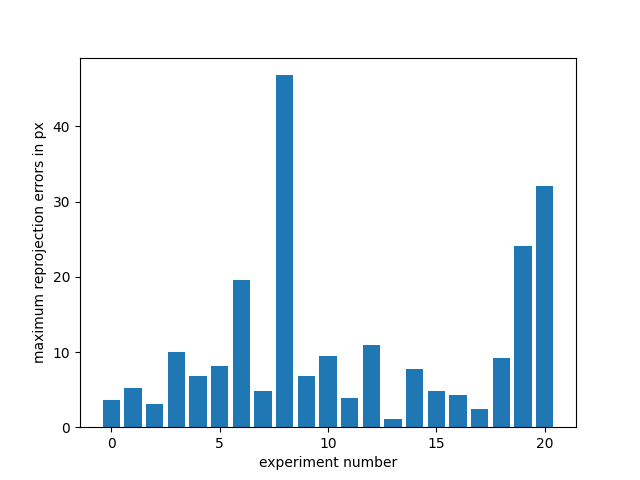

In [10]:
max_repr_errs = [np.max(re)  for re in repr_errs]
plt.figure()
plt.bar(idxs,max_repr_errs)
plt.ylabel("maximum reprojection errors in px")
plt.xlabel("experiment number")
plt.show()

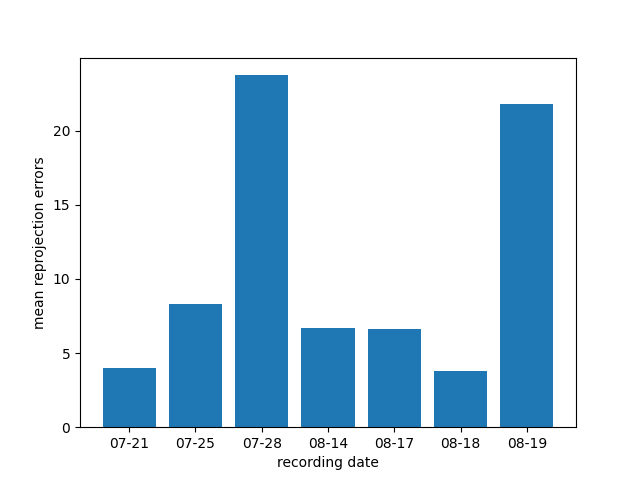

In [15]:
combined_errrs = [ np.mean((max_repr_errs[i],max_repr_errs[i+1],max_repr_errs[i+2])) for i in range(0,len(max_repr_errs),3)]
plt.figure()
plt.bar(scene_names,combined_errrs)
plt.ylabel("mean reprojection errors")
plt.xlabel("recording date")
#plt.savefig("/home/julian/Downloads/ushichka_experiment_reprojection_errs.eps")
plt.show()

In [7]:
# TODO Quality analysis similar to experiment_variation
def pinhole_pose(P):
    pose_hat = la.null_space(P) / la.null_space(P)[-1]
    return pose_hat[:3].flatten()

transformed_scenes = []
for i in range(0,len(exps),3):
    exp0 = exps[i]
    exp1 = exps[i+1]
    exp2 = exps[i+2]
    
    Ps_native = [exp0.load_imP(), exp1.load_imP(), exp2.load_imP()]
    transforms = [exp0.load_transform(), exp1.load_transform(), exp2.load_transform()]
    transformed_cameras = []
    for P_native in Ps_native:
        estimated_positions = []
        for trans in transforms:
            P_world = P_native @ la.inv(trans)
            poss_world = pinhole_pose(P_world)
            estimated_positions.append(poss_world)
        transformed_cameras.append(estimated_positions)
    transformed_scenes.append(transformed_cameras)
len(transformed_scenes)

        

7

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


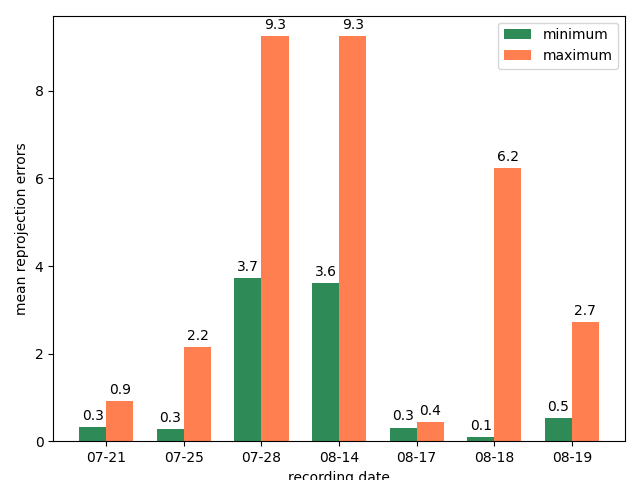

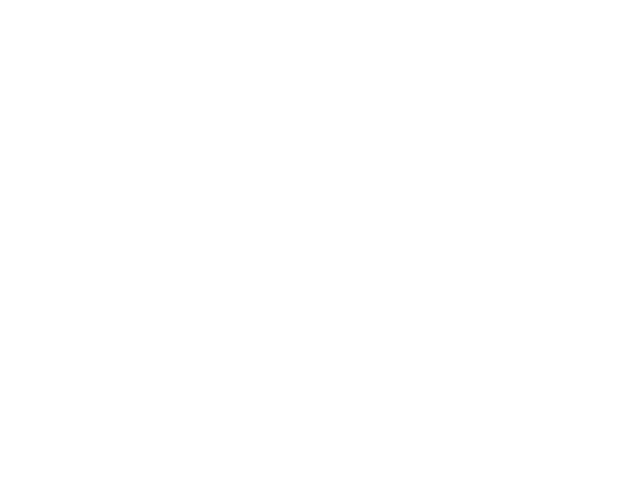

In [16]:
from itertools import combinations
def dists(points):
    dists = []
    for comb in combinations(points,2):
        p1, p2 = comb
        dist = la.norm(abs(p1 - p2))
        dists.append(dist)
    return dists

mean_min_dists = []
mean_max_dists = []
for scene in transformed_scenes:
    min_dist = [np.mean(min(dists(camera))) for camera in scene]
    mean_min_dists.append(np.mean(min_dist))
    max_dist = [np.mean(max(dists(camera))) for camera in scene]
    mean_max_dists.append(np.mean(max_dist))

x = np.arange(len(scene_names))  # the label locations
width = 0.35  # the width of the bars

plt.figure()
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mean_min_dists, width, label='minimum',color="seagreen")
rects2 = ax.bar(x + width/2, mean_max_dists, width, label='maximum',color="coral")

ax.set_ylabel('distance in meters')
#ax.set_title('m')
ax.set_xticks(x, scene_names)
ax.legend()

ax.bar_label(rects1,np.round(mean_min_dists,1), padding=3)
ax.bar_label(rects2, np.round(mean_max_dists,1) ,padding=3)

fig.tight_layout()

plt.ylabel("mean reprojection errors")
plt.xlabel("recording date")
#plt.savefig("/home/julian/Downloads/ushichka_experiment_camera_distances.eps")

plt.show()